The original way I had of handling the HRRR projection turned out to be imprecise, with up to almost 8km of error in the projection corners. Luckily, the GRIB files have the correct projection information and that works––mostly. Unfortunately, the projection created doesn't seem to work with matplotlib.

In [1]:
# You can get these with pygrib from any of the HRRR CONUS grib files:
#     import pygrib
#     grib_data = pygrib.open(grib_loc)
#     proj_params = grib_data[1].projparams


proj_params = {'a': 6371229,
               'b': 6371229,
               'proj': 'lcc',
               'lon_0': 262.5,
               'lat_0': 38.5,
               'lat_1': 38.5,
               'lat_2': 38.5}

I had to update to the newest version of cartopy (0.20.1), but it does have support to directly create a CRS projection from these.

In [ ]:
import cartopy.crs as ccrs
projection = ccrs.CRS(proj_params)

Let's try this out with an example HRRR Zarr:

In [3]:
import s3fs
import xarray as xr
from datetime import datetime
from metpy.units import units

def load_example_data():
    reference_time = datetime(2021, 7, 5, 19)
    var_name = "TMP"
    var_level = "surface"

    fs = s3fs.S3FileSystem(anon=True)
    root_url = reference_time.strftime("s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr")

    s3_lookups = [s3fs.S3Map(url, s3=fs) for url in [f"{root_url}/{var_level}/{var_name}", 
                                                     f"{root_url}/{var_level}/{var_name}/{var_level}"]]

    return xr.open_mfdataset(s3_lookups, engine="zarr")

surface_temp = load_example_data()

# SLC international airport
airport_lat, airport_lon = 40.47, -111.59
x, y = projection.transform_point(airport_lon, airport_lat, ccrs.PlateCarree())
temperature = surface_temp.sel(projection_x_coordinate=x, 
                               projection_y_coordinate=y, method="nearest").TMP.values

temperature = (temperature * units.kelvin).to(units.fahrenheit)
print(f"The temperature at SLC International Airport on July 5 at 19z was {temperature:.1f}")

The temperature at SLC International Airport on July 5 at 19z was 89.8 degree_Fahrenheit


We can also create a map of the data. Since the projection object doesn't work directly with matplotlib, first we generate the latitude and longitude values using metpy.

In [4]:
import metpy

def assign_coordinates(ds):
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    return ds

surface_temp = assign_coordinates(surface_temp)

Now all we have to do is map this from the (latitude and longitude) PlateCarree projection!

CPU times: user 1.46 s, sys: 113 ms, total: 1.57 s
Wall time: 2.52 s


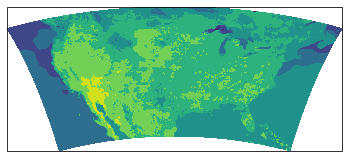

In [5]:
%%time
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(surface_temp.longitude, surface_temp.latitude, surface_temp.TMP)